In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=c72524b0e1df97fc5b22c530ac56a5cc49624d1be626ae512dfa2e57a6bbcc9c
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=4cf212ac226ab28a0ecc28a1f9d5066d37177baf9abc6f3d3d15074295db3c76
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 44100

In [ ]:
data_directory = pathlib.Path('data/maestro-v2.0.0')
if not data_directory.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data',
    )


59243107/59243107 [==============================] - 1s 0us/step


In [ ]:
midi_files = glob.glob(str(data_directory/'**/*.mid*'))
print('Number of files:', len(midi_files))

Number of files: 1282


In [ ]:
example_file = midi_files[1]
print(example_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_08_R3_2008_01-05_ORIG_MID--AUDIO_08_R3_2008_wav--3.midi


In [ ]:
pm = pretty_midi.PrettyMIDI(example_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=10):
  sound_wave = pm.fluidsynth(fs=_SAMPLING_RATE)
  sound_wave_short = sound_wave[:seconds*_SAMPLING_RATE]
  return display.Audio(sound_wave_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
print('Number of instruments:', len(pm.instruments))
selected_instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(selected_instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
for i, note in enumerate(selected_instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=65, note_name=F4, duration=0.7539
1: pitch=62, note_name=D4, duration=0.7695
2: pitch=50, note_name=D3, duration=1.0339
3: pitch=60, note_name=C4, duration=0.7760
4: pitch=64, note_name=E4, duration=0.7721
5: pitch=69, note_name=A4, duration=2.2786
6: pitch=62, note_name=D4, duration=1.0104
7: pitch=52, note_name=E3, duration=1.0326
8: pitch=68, note_name=G#4, duration=0.2799
9: pitch=59, note_name=B3, duration=1.1003


In [ ]:
def midifile_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  selected_instrument = pm.instruments[0]
  notes = collections.defaultdict(list)


  sorted_notes = sorted(selected_instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
extracted_notes = midifile_to_notes(example_file)
extracted_notes.head()

,pitch,start,end,step,duration
0,69,0.954427,3.233073,0.000000,2.278646
1,65,0.980469,1.734375,0.026042,0.753906
2,50,0.989583,2.023438,0.009115,1.033854
3,62,0.993490,1.763021,0.003906,0.769531
4,60,1.707031,2.483073,0.713542,0.776042


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(extracted_notes['pitch'])
sample_note_names[:10]

array(['A4', 'F4', 'D3', 'D4', 'C4', 'E4', 'D4', 'B3', 'E3', 'G#4'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

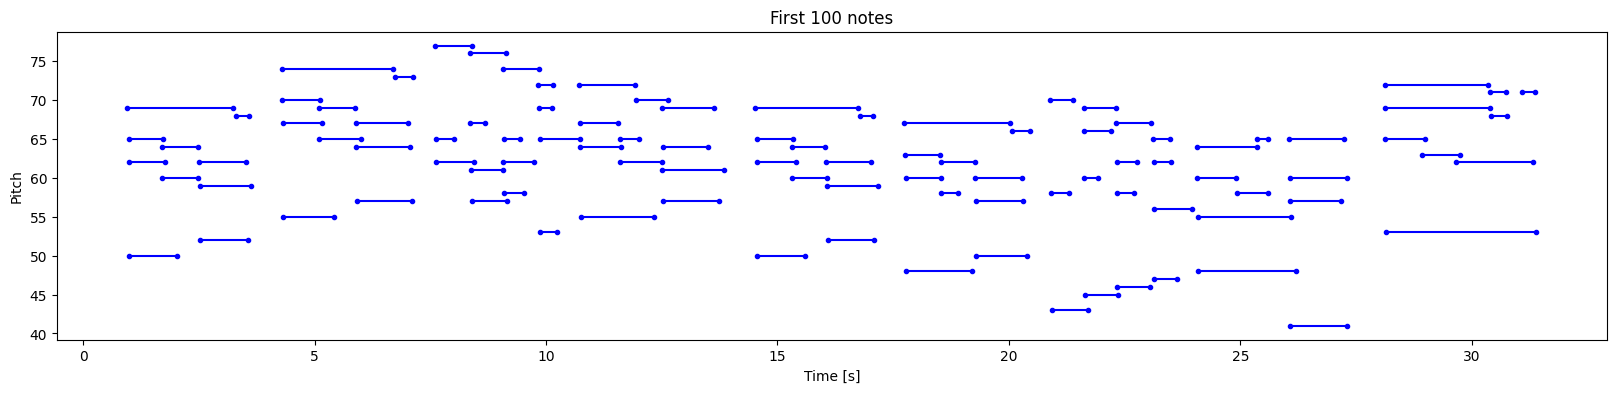

In [ ]:
plot_piano_roll(extracted_notes, count=100)

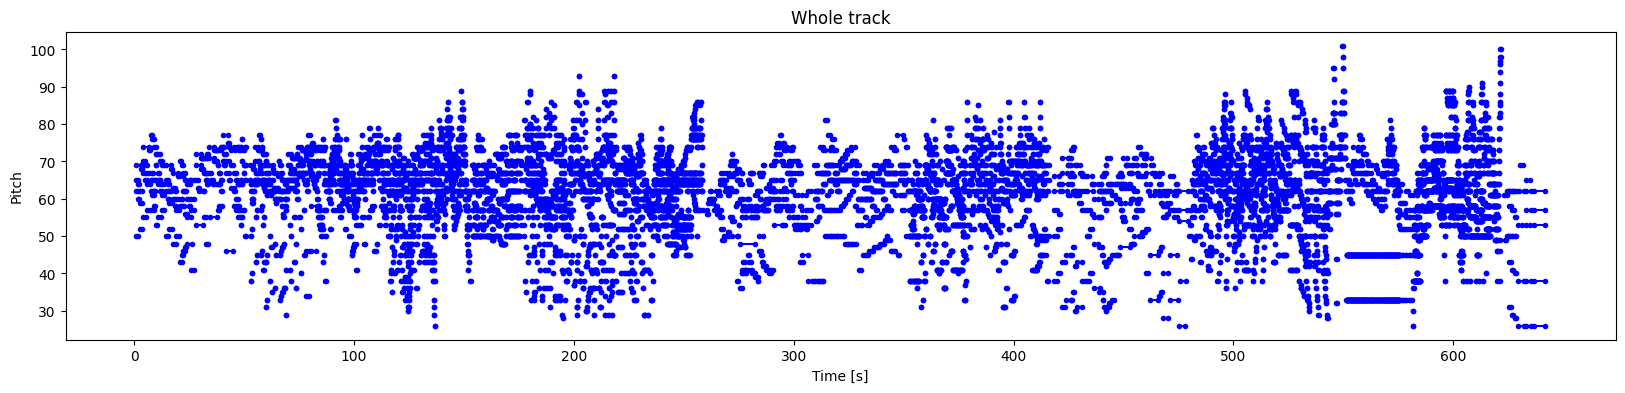

In [ ]:
plot_piano_roll(extracted_notes)

In [ ]:
def visualize_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

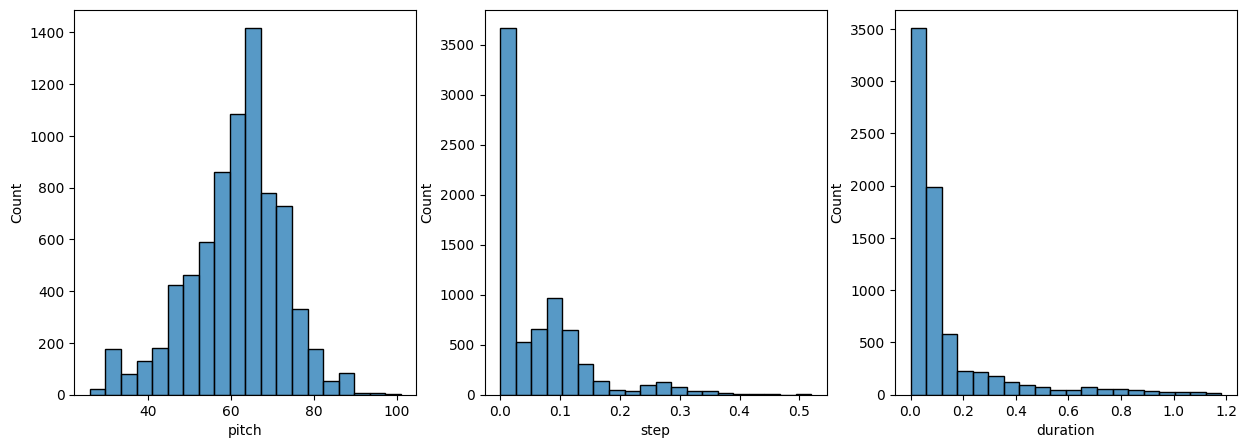

In [ ]:
visualize_distributions(extracted_notes)

In [ ]:
def notes_to_midifile(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
file = 'file.midi'
example_pm = notes_to_midifile(
    extracted_notes, out_file=file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

In [ ]:
num = 5
all_notes = []
for f in midi_files[:num]:
  notes = midifile_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 21993


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_seq(
    dataset: tf.data.Dataset,
    len_seq: int,
    vocab_size = 128,
) -> tf.data.Dataset:

  len_seq = len_seq+1


  windows = dataset.window(len_seq, shift=1, stride=1,
                              drop_remainder=True)


  flatten = lambda x: x.batch(len_seq, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
len_seq = 25
vocab_size = 128
seq_ds = create_seq(notes_ds, len_seq, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.40625    0.         0.03515625]
 [0.5        0.00260417 0.03385417]
 [0.40625    0.11197917 0.03776042]
 [0.5        0.00911458 0.03515625]
 [0.5        0.10286458 0.02864583]
 [0.40625    0.00130208 0.03255208]
 [0.40625    0.34114583 0.04036458]
 [0.5        0.00390625 0.0390625 ]
 [0.40625    0.38411458 0.03255208]
 [0.5        0.0078125  0.03125   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=31.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.006510416666666963>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.03255208333333304>}


In [ ]:
batch_size = 64
buffer_size = n_notes - len_seq
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
def func_positive_pres(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (len_seq, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': func_positive_pres,
      'duration': func_positive_pres,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

343/343 [==============================] - 11s 16ms/step - loss: 5.4649 - duration_loss: 0.5597 - pitch_loss: 4.8451 - step_loss: 0.0600


{'loss': 5.464890003204346,
 'duration_loss': 0.5597354173660278,
 'pitch_loss': 4.845119476318359,
 'step_loss': 0.06003371998667717}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

343/343 [==============================] - 6s 16ms/step - loss: 0.8620 - duration_loss: 0.5597 - pitch_loss: 4.8451 - step_loss: 0.0600


{'loss': 0.8620254993438721,
 'duration_loss': 0.5597354173660278,
 'pitch_loss': 4.845119476318359,
 'step_loss': 0.06003371998667717}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
343/343 [==============================] - 18s 45ms/step - loss: 0.2831 - duration_loss: 0.0594 - pitch_loss: 4.1679 - step_loss: 0.0153
Epoch 2/50
343/343 [==============================] - 16s 45ms/step - loss: 0.2689 - duration_loss: 0.0533 - pitch_loss: 4.0293 - step_loss: 0.0142
Epoch 3/50
343/343 [==============================] - 16s 47ms/step - loss: 0.2650 - duration_loss: 0.0522 - pitch_loss: 3.9757 - step_loss: 0.0140
Epoch 4/50
343/343 [==============================] - 15s 44ms/step - loss: 0.2614 - duration_loss: 0.0513 - pitch_loss: 3.9250 - step_loss: 0.0139
Epoch 5/50
343/343 [==============================] - 15s 45ms/step - loss: 0.2590 - duration_loss: 0.0509 - pitch_loss: 3.8882 - step_loss: 0.0137
Epoch 6/50
343/343 [==============================] - 15s 43ms/step - loss: 0.2575 - duration_loss: 0.0502 - pitch_loss: 3.8749 - step_loss: 0.0135
Epoch 7/50
343/343 [==============================] - 15s 44ms/step - loss: 0.2576 - duration_loss: 0.0505 - pit

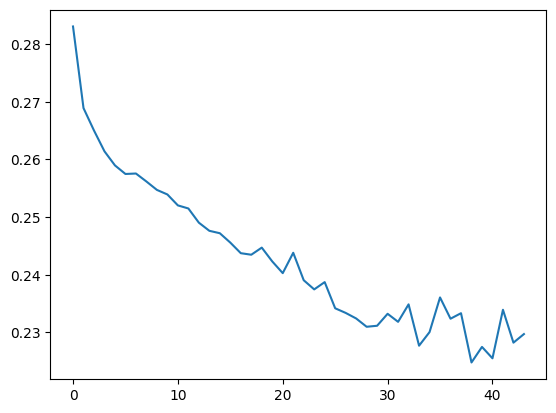

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:


  assert temperature > 0

  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)


  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([extracted_notes[key] for key in key_order], axis=1)


input_notes = (
    sample_notes[:len_seq] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 46ms/step


In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,43,0.133900,0.788073,0.133900,0.921973
1,101,0.341142,0.844407,0.475042,1.319449
2,81,0.372857,0.903012,0.847900,1.750912
3,93,0.389611,1.005417,1.237510,2.242928
4,52,0.387182,0.999069,1.624692,2.623761
5,104,0.398074,1.033787,2.022766,3.056552
6,97,0.375934,0.877045,2.398700,3.275745
7,101,0.388164,0.996411,2.786864,3.783275
8,86,0.379371,0.919254,3.166235,4.085489
9,80,0.372915,0.816441,3.539150,4.355591


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midifile(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

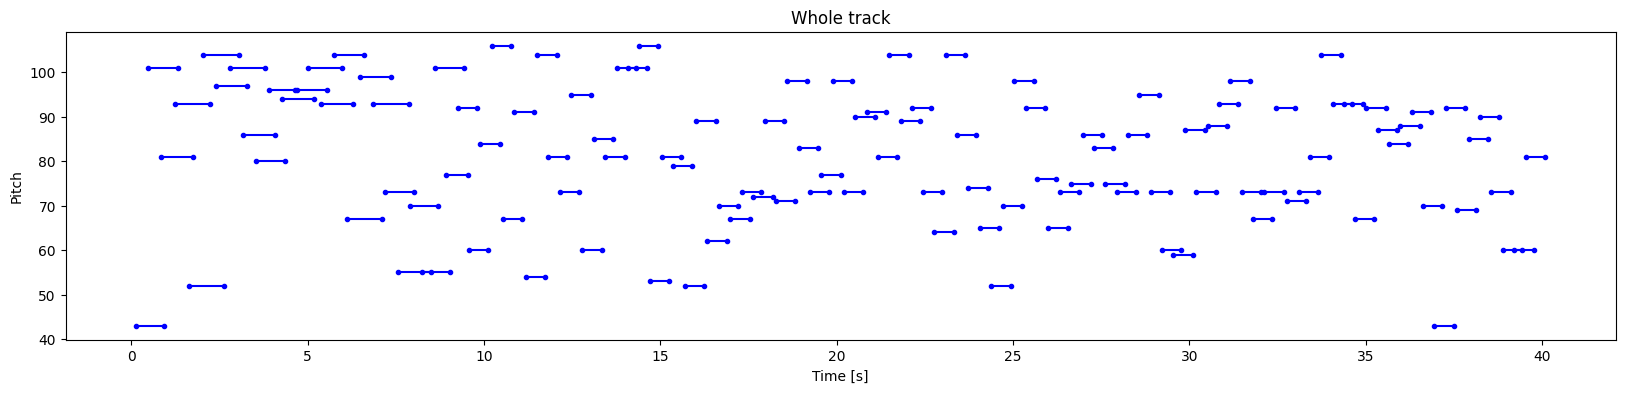

In [ ]:
plot_piano_roll(generated_notes)

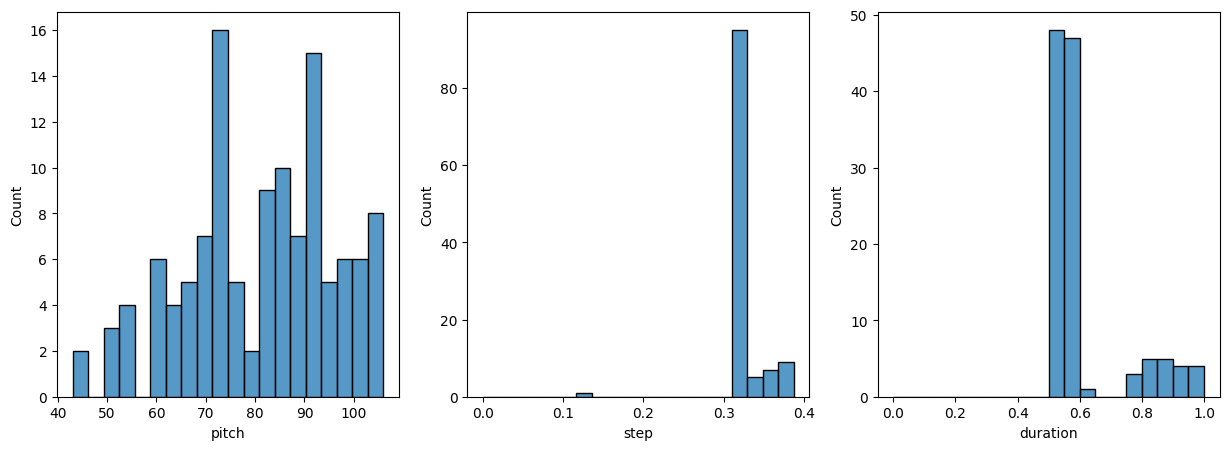

In [ ]:
visualize_distributions(generated_notes)